## <font color = 'purple'>Notebook 13: Gated Recurrent Unit (GRU)</font>

<font color = 'purple'>A Gated Recurrent Unit (GRU) is a type of recurrent neural network that uses gating mechanisms to manage the flow of information, efficiently capturing dependencies in sequential data. It helps prevent the vanishing gradient problem and is faster and simpler than LSTM networks.</font>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving main_dataset.xlsx to main_dataset.xlsx


In [ ]:
# Libraries for data processing
import numpy as np
import pandas as pd

# Libraries for text processing and NLP
import nltk
from textblob import TextBlob

# Gensim library for topic modelling and text vectorisation
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

# Libraries for data visualisation
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous imports
import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_excel('main_dataset.xlsx')

print("Shape of the dataset:", df.shape)
print("Columns in the dataset:", df.columns)

df.head()

Shape of the dataset: (44855, 4)
Columns in the dataset: Index(['date', 'review', 'rating', 'userName'], dtype='object')


,date,review,rating,userName
0,2021-05-06 05:15:00.000,This feature has been one of the most annoying...,5,Keanu De Sousa
1,2024-02-01 09:06:59.904,"The privacy on WhatsApp is incredible, I know ...",4,The great idea!!!
2,2023-08-14 05:42:00.000,"Hi WhatsApp,\nThis app is really great, I use ...",4,Pokey Ball ‚öæÔ∏è
3,2024-08-04 15:53:00.384,If there was ever an equivalent of social serv...,1,Zenicero
4,2024-05-26 01:12:59.616,Im on holiday and reliant on whatsapp to commu...,1,JohnDoe63737286


In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if you haven't already
nltk.download('stopwords')

# Set of stopwords in English
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Split text into words and remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]

    # Join the filtered words back into a single string
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

# Apply the updated preprocess_text function to your dataset
df['content_cleaned'] = df['review'].apply(preprocess_text)

# Display the first few rows of the cleaned content
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,date,review,rating,userName,content_cleaned
0,2021-05-06 05:15:00.000,This feature has been one of the most annoying...,5,Keanu De Sousa,feature one annoying aspects whatsapp everytim...
1,2024-02-01 09:06:59.904,"The privacy on WhatsApp is incredible, I know ...",4,The great idea!!!,privacy whatsapp incredible know probably donä...
2,2023-08-14 05:42:00.000,"Hi WhatsApp,\nThis app is really great, I use ...",4,Pokey Ball ‚öæÔ∏è,hi whatsapp app really great use everyday exac...
3,2024-08-04 15:53:00.384,If there was ever an equivalent of social serv...,1,Zenicero,ever equivalent social services took words awa...
4,2024-05-26 01:12:59.616,Im on holiday and reliant on whatsapp to commu...,1,JohnDoe63737286,im holiday reliant whatsapp communicate agents...


In [ ]:
df.isnull()
total_null_values = df.isnull().sum().sum()
print("Total null values in the DataFrame: ", total_null_values)
df.fillna('', inplace = True)
df['date'] = pd.to_datetime(df['date'], dayfirst = True)
df = df[['content_cleaned', 'review', 'rating', 'date']]
df.head()

Total null values in the DataFrame:  12


,content_cleaned,review,rating,date
0,feature one annoying aspects whatsapp everytim...,This feature has been one of the most annoying...,5,2021-05-06 05:15:00.000
1,privacy whatsapp incredible know probably donä...,"The privacy on WhatsApp is incredible, I know ...",4,2024-02-01 09:06:59.904
2,hi whatsapp app really great use everyday exac...,"Hi WhatsApp,\nThis app is really great, I use ...",4,2023-08-14 05:42:00.000
3,ever equivalent social services took words awa...,If there was ever an equivalent of social serv...,1,2024-08-04 15:53:00.384
4,im holiday reliant whatsapp communicate agents...,Im on holiday and reliant on whatsapp to commu...,1,2024-05-26 01:12:59.616


In [ ]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['content_cleaned'].apply(get_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0.1 else
                                             ('negative' if x <- 0.1 else 'neutral'))

In [ ]:
df[['content_cleaned', 'rating', 'sentiment_label']]

,content_cleaned,rating,sentiment_label
0,feature one annoying aspects whatsapp everytim...,5,negative
1,privacy whatsapp incredible know probably donä...,4,positive
2,hi whatsapp app really great use everyday exac...,4,positive
3,ever equivalent social services took words awa...,1,positive
4,im holiday reliant whatsapp communicate agents...,1,negative
...,...,...,...
44850,free delivery prime,5,positive
44851,would expectamazon trying get hand pocket,3,neutral
44852,registry system mess sorting price low high wa...,2,neutral
44853,clothes furniture options kinda meh overall de...,3,neutral


In [ ]:
# Import necessary libraries for model building
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
# Define parameters
max_words = 10000 # Maximum number of words in the vocabulary
max_len = 100 # Maximum sequence length
embedding_dim = 100 # Embedding dimension for word embeddings

In [ ]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(df['content_cleaned'])

In [ ]:
sequences = tokenizer.texts_to_sequences(df['content_cleaned'])

In [ ]:
X = pad_sequences(sequences, maxlen = max_len)

In [ ]:
df['sentiment_label_num'] = df['sentiment_label'].map({'positive': 1, 'negative': 0, 'neutral': 2})
y = to_categorical(df['sentiment_label_num'], num_classes = 3) # One-hot encode for multiclass classification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(GRU(units=128, return_sequences=False))  # Set units, e.g., 128

model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 123s 266ms/step - accuracy: 0.7423 - loss: 0.5702 - val_accuracy: 0.9117 - val_loss: 0.2353
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 140s 262ms/step - accuracy: 0.9543 - loss: 0.1317 - val_accuracy: 0.9507 - val_loss: 0.1431
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 145s 270ms/step - accuracy: 0.9801 - loss: 0.0603 - val_accuracy: 0.9526 - val_loss: 0.1438
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 120s 268ms/step - accuracy: 0.9874 - loss: 0.0386 - val_accuracy: 0.9554 - val_loss: 0.1496
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 119s 265ms/step - accuracy: 0.9909 - loss: 0.0294 - val_accuracy: 0.9536 - val_loss: 0.1909
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9480 - loss: 0.2007
Test Accuracy: 0.9506186842918396


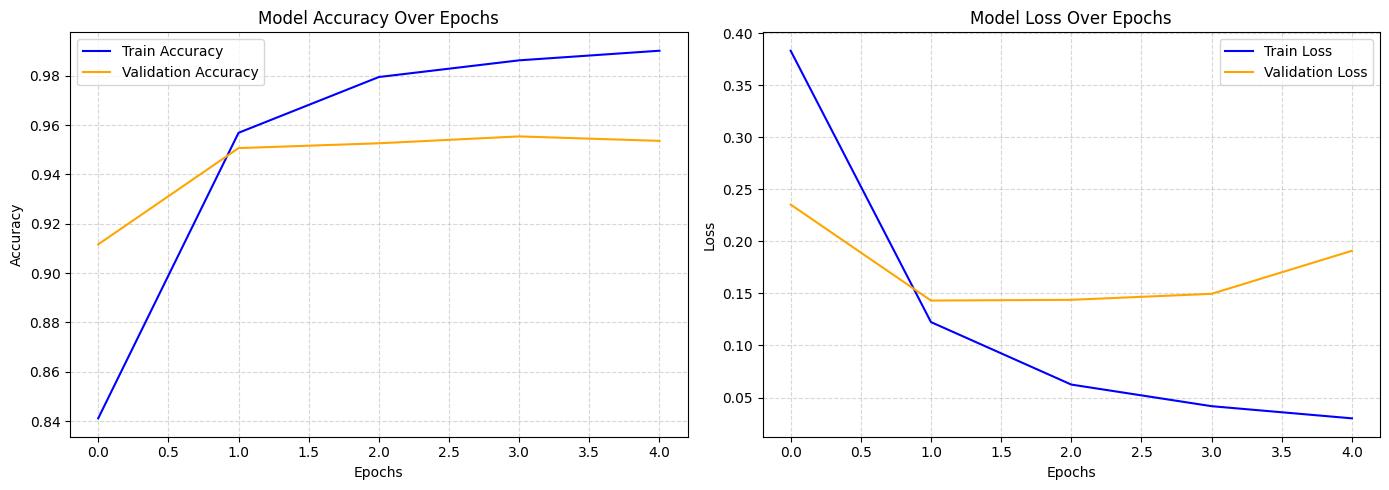

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()